In [1]:
from mxnet import gluon
from mxnet import nd
from mxnet import autograd as ag

## 使用数据集
这次使用的数据集是 **Fashion Mnist**.**FashionMNIST** 是一个替代 **MNIST** 手写数字集的图像数据集。 它是由 Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自 10 种类别的共 7 万个不同商品的正面图片。

FashionMNIST 的大小、格式和训练集/测试集划分与原始的 MNIST 完全一致。**60000/10000** 的训练测试数据划分，28x28 的灰度图片。你可以直接用它来测试你的机器学习和深度学习算法性能，且不需要改动任何的代码。
替代MNIST的原因： MNIST 太简单了，很多算法在测试集上的性能已经达到 99.6%！而且Fashion Mnist已经得到业内人士的认可。
![image](../image/FashionMnist.jpeg)

### 下载/读取数据集
第一次的时候会下载，后面就可以直接使用了

In [2]:
def transform(data, label):
    return data.astype('float32')/255, label.astype('float32')
train_mnist = gluon.data.vision.FashionMNIST(train=True, transform=transform)
test_mnist = gluon.data.vision.FashionMNIST(train=False, transform=transform)

In [3]:
import matplotlib.pyplot as plt
def show_images(images):
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28,28)).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()

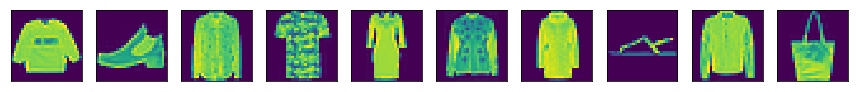

In [4]:
data, label = train_mnist[0:10]
show_images(data)

| 标注标号 | 描述              |
| ---------| ------------------|
| 0        | T-shiirt/top(T恤）|
| 1        |Trouser(裤子）|
| 2        |Pullover(套衫）|
| 3        |Dress(裙子）|
| 4        |Coat(外套）|
| 5        |Sandal(凉鞋）|
| 6        |Shirt(汗衫）|
| 7        |Sneake(运动鞋）|
| 8        |Bag(包）|
| 9        |Ankle boot(裸靴）|

### 数据读取
直接使用`gluon`的DataLoader函数，每次yield一个批量

In [4]:
batch_size = 256
train_data = gluon.data.DataLoader(train_mnist, batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_mnist, batch_size, shuffle=False)

### 初始化模型参数
跟线性模型一样，每个样本会表示成一个向量。我们这里是 28*28 大小的图片，所以输入向量的长度是 28*28=784. 因为数据集有10个类型，所以需要输出一个长度为10的向量，所以我们需要一个 784*10的权重矩阵

In [6]:
num_inputs = 784
num_outputs = 10

W = 0.01 * nd.random_normal(shape=(num_inputs,num_outputs))
b = nd.random_normal(shape=num_outputs)

params = [W, b]
for param in params:
    param.attach_grad()

### 定义模型
在线性回归模型里，我们只需要输出一个标量yhat使得尽可能的靠近目标值。但在这里的分类里，我们需要属于每个类别的概率。这些概率需要值为正，而且加起来和为1.如果使用`yhat = W*x`不能保证这一点。一个通常的做法是通过 Softmax 将任意的输入归一化成合法的概率值。

In [7]:
from mxnet import nd
def softmax(X):
    exp = nd.exp(X)
    # 假设exp是矩阵， 这里进行求和， 病要求axis=1,
    # 就是返回（nrows, 1) 形状的矩阵
    partition = exp.sum(axis=1, keepdims=True)
    return exp / partition
    

In [8]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)),  W) +b)

### 交叉熵损失函数
我们需要定义一个针对预测为概率值的损失函数。其中最常见的是交叉熵损失函数，它将两个概率分布的负交叉熵作为目标值，最小化这个值等价于最大化这两个概率的相似度。

具体来说，我们先将真是标号表示成一个概率分布，例如如果y=1,那么其对应的分布就是一个除了第二个元素为1其他全为0的唱为10的向量


In [9]:
def cross_entropy(yhat, y):
    return -nd.log(nd.pick(yhat, y))

### 计算精度
给定一个概率输出，我们将预测概率最高的那个类作为预测的类，然后通过比较真实标号我们可以计算精度：

In [10]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

In [11]:
def evaluate_accuracy(data_iterator, net):
    acc = 0.
    for data, label in data_iterator:
        output = net(data)
        acc += accuracy(output, label)
    return acc /len(data_iterator)

因为我们随机初始化了模型， 所以这个模型的精度应该大概是 `1/num_outputs = 0.1`

In [12]:
evaluate_accuracy(test_data, net)

0.103515625

### 训练模型

In [13]:
from mxnet import autograd

In [14]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [15]:
learning_rate = 0.1

for epoch in range(5):
    train_loss = 0.
    train_acc = 0.
    i = 0
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label)
        if i ==0 or i==100 or i ==200:
            a = nd.exp(nd.dot(data.reshape((-1, num_inputs)),  W) +b)
            partition = a.sum(axis=1, keepdims=True)
        loss.backward()
        #j 将梯度做平均， 这样学习率会对batch_size不那么敏感
        SGD(params, learning_rate/batch_size)

        i += 1
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)
    test_acc = evaluate_accuracy(test_data, net)
    print("Epoch %d. Loss: %f, Train acc %f, Test acc %f" %(
        epoch, train_loss/len(train_data), train_acc/len(train_data), test_acc))

Epoch 0. Loss: 0.789588, Train acc 0.745667, Test acc 0.799609
Epoch 1. Loss: 0.573887, Train acc 0.807984, Test acc 0.814551
Epoch 2. Loss: 0.529324, Train acc 0.820711, Test acc 0.824121
Epoch 3. Loss: 0.506211, Train acc 0.827521, Test acc 0.831055
Epoch 4. Loss: 0.489538, Train acc 0.831887, Test acc 0.836426


如果`W`初始化的时候，不给一个比较小的数，刚开始的效果比较差；给一个比较小的参数，收敛会更快

### 预测

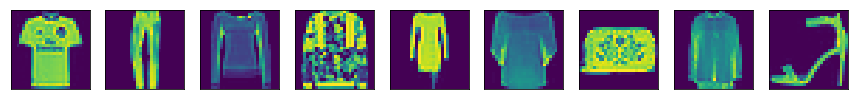

true labels
[0. 1. 2. 2. 3. 2. 8. 6. 5.]
predicted labels

[0. 1. 2. 2. 4. 6. 8. 6. 5.]
<NDArray 9 @cpu(0)>


In [16]:
data, label = test_mnist[0:9]
show_images(data)
print('true labels')
print(label)

predicted_labels = net(data).argmax(axis=1)
print('predicted labels')
print(predicted_labels)

### 结论
与前面的线性回归相比，你会发现多类逻辑回归教程的结构跟其非常相似；获取数据、定义模型、及优化算法和求解。事实上，几乎所有的神经网络应用都有着相同的结构。他们的主要区别就在于模型的类型和数据的规模。每一两年会有一两种新的优化算法出来，但它们基本都是随机梯度下降的变种。

### 思考
尝试增大学习率，你会发现结果马上会变得很糟，精度基本会徘徊在随机的0.1左右，为什么？
提示：
- 打印下output看看是不是有什么异常
- 前面线性回归还好好的，这里我们在net（）里加了什么呢？
- 如果给exp输入个很大的数会是什么样的
- 即使解决exp的问题，求出来的导数是不是还是不稳定？

[Mxnet主开发者pluskid关于Softmax数值稳定性的解释](http://freemind.pluskid.org/machine-learning/softmax-vs-softmax-loss-numerical-stability/)

# Gluon版本

### 定义模型 及参数初始化

In [17]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(10))
net.initialize()

### Softmax和交叉熵损失函数
分开定义 softmax 和 交叉熵损失函数会存在数值不稳定；所以gluon会把soft和交叉熵损失函数结合在一起变成一层，这样数值更稳定

In [18]:
soft_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

### 优化

In [19]:
trainer = gluon.Trainer(net.collect_params(),  'sgd',  {'learning_rate':0.1})

### 训练

In [20]:
num_epochs = 5
lr = 0.1
for epoch in range(5):
    train_loss = 0.
    train_acc = 0.
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = soft_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)
    test_acc = evaluate_accuracy(test_data, net)
    print("Epoch %d. Loss: %f, Train acc %f, Test acc %f" %(
        epoch, train_loss/len(train_data), train_acc/len(train_data), test_acc))

Epoch 0. Loss: 0.800911, Train acc 0.736320, Test acc 0.796973
Epoch 1. Loss: 0.577943, Train acc 0.809070, Test acc 0.821777
Epoch 2. Loss: 0.531711, Train acc 0.822645, Test acc 0.829590
Epoch 3. Loss: 0.506919, Train acc 0.829233, Test acc 0.834180
Epoch 4. Loss: 0.491448, Train acc 0.833433, Test acc 0.840137


In [21]:
nd.Activation?